In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
from pandas import DataFrame

In [103]:
# List all benchmark versions to merge together
benchmark_versions: list = ['v0.9', 'v1.0', 'v1.5', 'v1.5_quantized']
merged_df = []

for i, benchmark_versions in enumerate(benchmark_versions):
    raw_df: DataFrame = pd.read_csv(f'./{benchmark_versions}/raw.csv')

    # change the episode name by appending the benchmark version. This helps to avoid duplicate error in pivot function
    raw_df.episode = raw_df.episode.map(lambda x: f'{x}_{benchmark_versions}')

    # merge the new benchmark version to all previous ones
    merged_df = raw_df if i == 0 else pd.concat([merged_df, raw_df], axis=0)

In [193]:
def plot_histogram_of_all_playable_episodes(df):
    metriclist = ['Success', 'Aborted', 'Lose']
    df_aux = df[df.metric.isin(metriclist)]

    # Pivot the DataFrame
    df_pivot = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                             columns='metric',
                             values='value')
                .reset_index()
                .drop(columns=['experiment', 'episode'])
                .groupby(['model', 'game'])
                .sum()
                .drop(columns=['Lose', 'Aborted']))

    # Reset the index to have 'game' as columns and 'model' as rows
    df_stacked = df_pivot.reset_index().pivot(index='model', columns='game', values='Success').fillna(0)

    # compute the total successes among all games
    df_stacked['total_success'] = df_stacked.sum(axis=1)

    df_stacked.total_success.plot(kind='hist', bins=30, log=True)

    plt.xlabel('Total Number of Successfully played Episodes')
    plt.ylabel('Count of Models LOG SCALE')
    plt.title("Distribution of Successfully played Episodes clustered by Model among Benchmark versions v0.9 - v1.5_quantized")

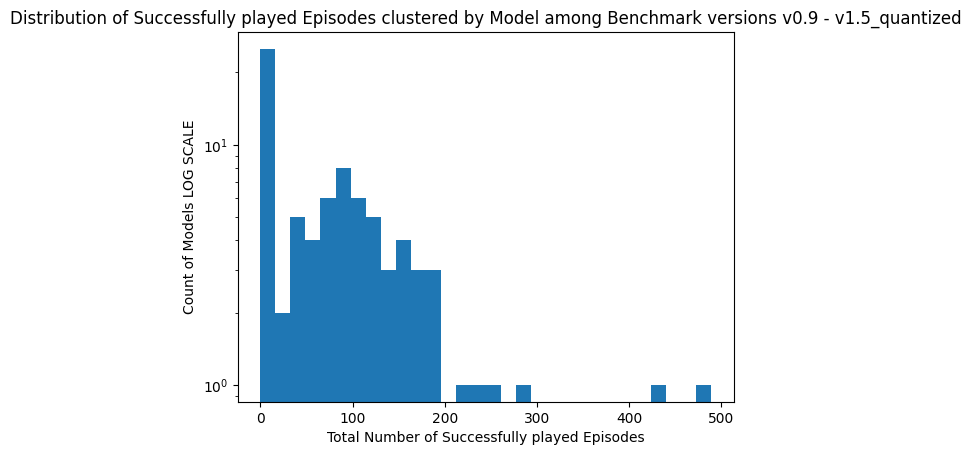

In [194]:
plot_histogram_of_all_playable_episodes(merged_df)

In [195]:
def stackplot(raw_df, title='Stacked Barplot Clustered by Game Type and Outcome'):
    STACK_COLORS = ['darkolivegreen', 'indianred', 'gray']
    metriclist = ['Success', 'Aborted', 'Lose']
    df_aux = raw_df[raw_df.metric.isin(metriclist)]

    df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                           columns='metric',
                           values='value')
              .reset_index()
              .drop(columns=['model', 'experiment', 'episode'])
              .groupby('game')
              .sum()
              .sort_values(axis=1, by='metric', ascending=False))
    df_aux.plot(kind='barh',
                stacked=True,
                figsize=(5, 5),
                colormap=ListedColormap(STACK_COLORS))

    plt.title(title)
    plt.legend(loc='lower center', ncols=3)
    plt.xlabel('Number of played episodes')
    plt.show()

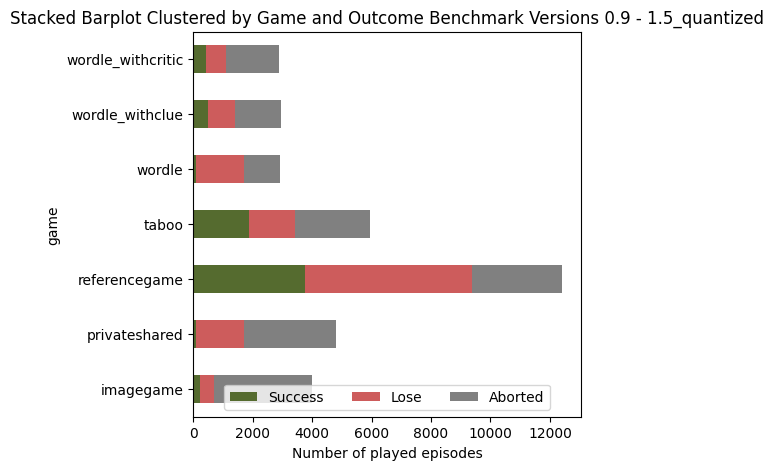

In [196]:
stackplot(merged_df, title='Stacked Barplot Clustered by Game and Outcome Benchmark Versions 0.9 - 1.5_quantized')

In [197]:
def get_top_k_models(df, k=10):
    metriclist = ['Success', 'Aborted', 'Lose']
    df_aux = df[df.metric.isin(metriclist)]

    # Pivot the DataFrame
    df_pivot = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                             columns='metric',
                             values='value')
                .reset_index()
                .drop(columns=['experiment', 'episode'])
                .groupby(['model', 'game'])
                .sum()
                .drop(columns=['Lose', 'Aborted']))

    # Reset the index to have 'game' as columns and 'model' as rows
    df_stacked = df_pivot.reset_index().pivot(index='model', columns='game', values='Success').fillna(0)

    # compute the total successes among all games
    df_stacked['total_success'] = df_stacked.sum(axis=1)
    df_stacked = df_stacked.sort_values(by='total_success', ascending=False)
    return df_stacked.head(k)

In [198]:
# get the top k models with the most total successful episodes among all games
models_to_include: list = list(get_top_k_models(merged_df, 10).index)

# filter merged df to only include top k models
merged_df_top_k = merged_df[merged_df.model.isin(models_to_include)]

In [216]:
def custom_stacked_barplot(df, title):
    metriclist = ['Success', 'Aborted', 'Lose']
    df_aux = df[df.metric.isin(metriclist)]

    # Pivot the DataFrame
    df_pivot = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                             columns='metric',
                             values='value')
                .reset_index()
                .drop(columns=['experiment', 'episode'])
                .groupby(['model', 'game'])
                .sum()
                .drop(columns=['Lose', 'Aborted']))

    # Reset the index to have 'game' as columns and 'model' as rows
    df_stacked = df_pivot.reset_index().pivot(index='model', columns='game', values='Success').fillna(0)
    df_stacked['total_success'] = df_stacked.sum(axis=1)
    df_stacked = df_stacked.sort_values(by='total_success', ascending=True)
    df_stacked = df_stacked.drop(columns=['total_success'])

    # Plotting the stacked bar plot
    df_stacked.plot(kind='barh', stacked=True)

    # Adding labels and title
    plt.xlabel('Successes per Game')
    plt.ylabel('Model')
    plt.title(title)
    plt.legend(title='Game')

    # Display the plot
    plt.show()

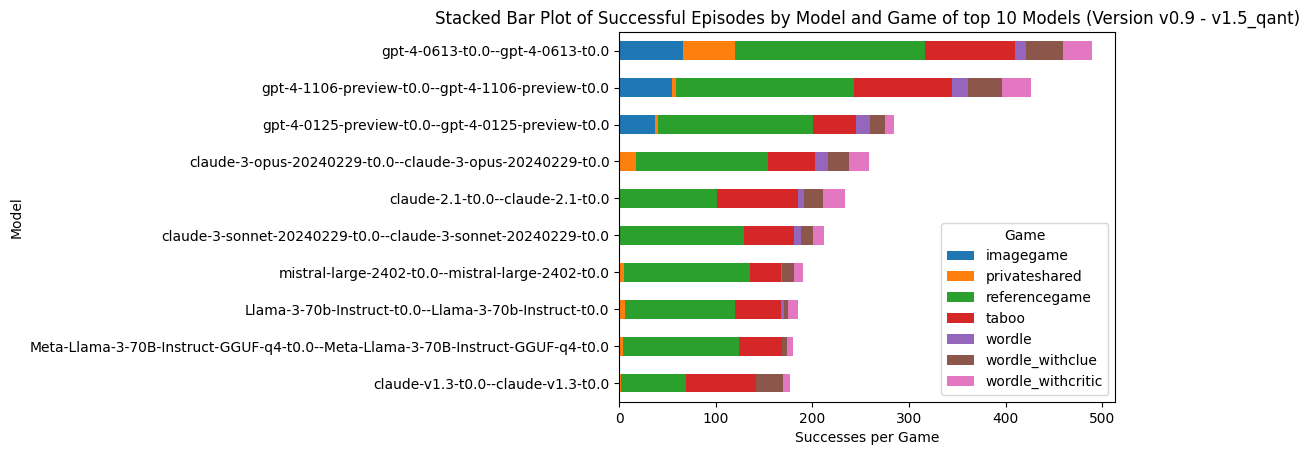

In [218]:
custom_stacked_barplot(merged_df_top_k, title='Stacked Bar Plot of Successful Episodes by Model and Game of top 10 Models (Version v0.9 - v1.5_qant)')

In [88]:
merged_df.head()

,index,game,model,experiment,episode,metric,value
0,0,taboo,luminous-supreme-t0.0--luminous-supreme-t0.0,0_high_en,episode_5_v09_v09,Violated Request Count,1.0
1,1,taboo,luminous-supreme-t0.0--luminous-supreme-t0.0,0_high_en,episode_5_v09_v09,Parsed Request Count,0.0
2,2,taboo,luminous-supreme-t0.0--luminous-supreme-t0.0,0_high_en,episode_5_v09_v09,Request Count,1.0
3,3,taboo,luminous-supreme-t0.0--luminous-supreme-t0.0,0_high_en,episode_5_v09_v09,Request Success Ratio,0.0
4,4,taboo,luminous-supreme-t0.0--luminous-supreme-t0.0,0_high_en,episode_5_v09_v09,Aborted,1.0


In [115]:
metriclist = ['Success', 'Aborted', 'Lose']
df_aux = merged_df[merged_df.metric.isin(metriclist)]

In [124]:
(df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
              columns='metric',
              values='value')
 .reset_index()
 .drop(columns=['experiment', 'episode'])
 .groupby(['model', 'game'])
 .sum()
 .sort_values(axis=1, by='metric', ascending=False).head(10000)
 .drop(columns=['Lose', 'Aborted']).head())

metric                                                            Success
model                                              game                  
CapybaraHermes-2.5-Mistral-7B-GGUF-q4-t0.0--Cap... imagegame          0.0
                                                   privateshared      0.0
                                                   referencegame     60.0
                                                   taboo             18.0
                                                   wordle             0.0

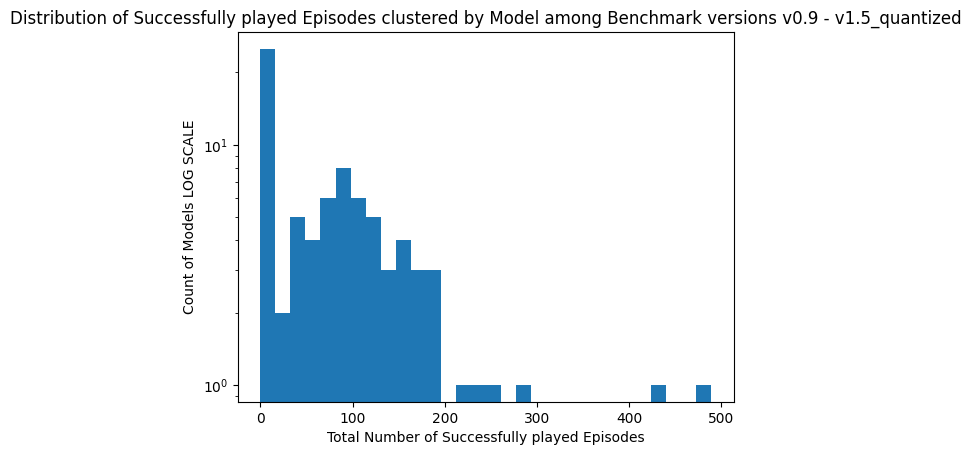

In [186]:
ordered_df: DataFrame = get_top_k_models(merged_df)
ordered_df.index

Index(['gpt-4-0613-t0.0--gpt-4-0613-t0.0',
       'gpt-4-1106-preview-t0.0--gpt-4-1106-preview-t0.0',
       'gpt-4-0125-preview-t0.0--gpt-4-0125-preview-t0.0',
       'claude-3-opus-20240229-t0.0--claude-3-opus-20240229-t0.0',
       'claude-2.1-t0.0--claude-2.1-t0.0',
       'claude-3-sonnet-20240229-t0.0--claude-3-sonnet-20240229-t0.0',
       'mistral-large-2402-t0.0--mistral-large-2402-t0.0',
       'Llama-3-70b-Instruct-t0.0--Llama-3-70b-Instruct-t0.0',
       'Meta-Llama-3-70B-Instruct-GGUF-q4-t0.0--Meta-Llama-3-70B-Instruct-GGUF-q4-t0.0',
       'claude-v1.3-t0.0--claude-v1.3-t0.0'],
      dtype='object', name='model')

In [187]:
models_to_include: list = list(ordered_df.index)

In [188]:
models_to_include

['gpt-4-0613-t0.0--gpt-4-0613-t0.0',
 'gpt-4-1106-preview-t0.0--gpt-4-1106-preview-t0.0',
 'gpt-4-0125-preview-t0.0--gpt-4-0125-preview-t0.0',
 'claude-3-opus-20240229-t0.0--claude-3-opus-20240229-t0.0',
 'claude-2.1-t0.0--claude-2.1-t0.0',
 'claude-3-sonnet-20240229-t0.0--claude-3-sonnet-20240229-t0.0',
 'mistral-large-2402-t0.0--mistral-large-2402-t0.0',
 'Llama-3-70b-Instruct-t0.0--Llama-3-70b-Instruct-t0.0',
 'Meta-Llama-3-70B-Instruct-GGUF-q4-t0.0--Meta-Llama-3-70B-Instruct-GGUF-q4-t0.0',
 'claude-v1.3-t0.0--claude-v1.3-t0.0']